# KL-divergence walk through

I'd like to understand whats happening in Nicoles Notebook so I go through it step by step.

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('code')
os.sys.path.append('../../code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import SlotAttentionPosEmbed

# Set numpy seed for test set sampling 
np.random.seed(24082023)

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cpu'

## Load a model

There are different configurations Nicole has tried and she loads the config file here:

In [4]:
cID_prev = 'learn-init-warm2'
with open(f'./../../code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

cd

{'data': {'N_clusters': 2, 'isRing': True},
 'hps': {'hidden_dim': 16,
  'k_slots': 3,
  'query_dim': 128,
  'softmax_T': 'default',
  'learn_init': True,
  'device': 'cpu'},
 'opt': {'lr': 0.000275, 'Ntrain': 1000000, 'bs': 256}}

Not sure why we need this random seed?

In [5]:
torch_seed = 29082023
torch.manual_seed( torch_seed )

import random
random.seed(torch_seed)

Now load the model `m` by using the funktion `SlotAttenionPosEmbed` from `model.py`

In [12]:
hps

{'hidden_dim': 16,
 'k_slots': 3,
 'query_dim': 128,
 'softmax_T': 'default',
 'learn_init': True,
 'device': 'cpu'}

In [13]:
del hps["learn_init"]
m = SlotAttentionPosEmbed(**hps)

In [14]:
print(m)

SlotAttentionPosEmbed(
  (dataN): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (queryN): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (toK): Linear(in_features=16, out_features=128, bias=True)
  (toV): Linear(in_features=16, out_features=128, bias=True)
  (gru): GRUCell(128, 128)
  (CNN_encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
  )
  (posEnc): SoftPositionalEmbed(
    (dense): Linear(in_features=4, out_features=16, bias=True)
  )
  (init_mlp): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  )
)


Ok. I do not see what form the input and output of the network should be???

Now load weights. These are from earlier training

In [23]:
lastIter = 900_000
weightPath = f'./../../code/models/{cID_prev}/m_{lastIter}.pt'
print(f'Starting from an earlier training',lastIter)

m.load_state_dict(torch.load(weightPath,map_location=device))

Starting from an earlier training 900000


<All keys matched successfully>

## Load some data

`bs` describes how much data should be generated (here: 100 pictures). `Kwargs` says "2 rings per image".
`make_batch` from `data.py` generates the data. `X` are the ring pictures, `y` are the attributes of the rings. 

`mask` are the regions of the two rings! E.g. which pixels have hits. 

In [24]:
bs = 100
kwargs = cd['data']

X,y, mask = make_batch(N_events=bs, **kwargs)

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/Walk-trough nbs /../../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


torch.Size([100, 1, 32, 32])
torch.Size([100, 2, 3])
Rings with  tensor([ 0.3949, -0.1920,  0.1855])  and  tensor([-0.4850,  0.4145,  0.1690])


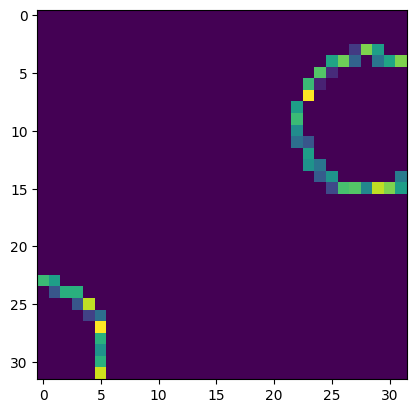

In [25]:
print(X.shape)
print(y.shape)
number = 2
plt.imshow(X[number][0])
print("Rings with ", y[number][0], " and ", y[number][1])

In [26]:
mask.shape

torch.Size([100, 2, 32, 32])

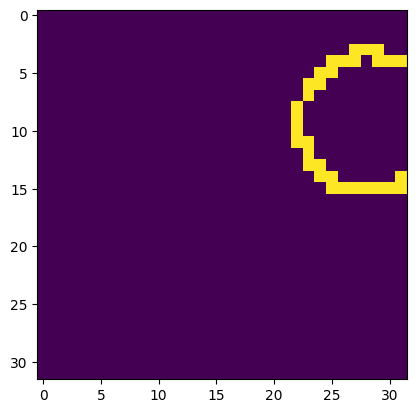

In [27]:
plt.imshow(mask[number][0])

## Evaluate the model

The model is already trained. But how can we check how good it is? Have a look at the loss!

In [28]:
from train import hungarian_matching
import torch.nn.functional as F

k_slots=3
max_n_rings=2
resolution=(32,32)

We do not want a gradient, we just like to evaluate the loss. We give `X` as an input to our model `m`. Then we check how well its output `att` matches `mask` by evalutating our binary_cross_entropy (BCE). We calculate the the "best matching" with the hungarian matching (I don't quite get the steps here...). End of the story: Got a number (loss) for each picture.

In [29]:
with torch.no_grad():

    torch.manual_seed(torch_seed)
    queries, att, wts = m(X)
    print(att.shape)
    #print(queries, att, wts)

    flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))

    att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
    mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 

    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
    print(pairwise_cost.shape)

    indices = hungarian_matching(pairwise_cost)
    print(indices.shape)

    # Apply the sorting to the predict
    bis=torch.arange(bs).to(device)
    indices=indices.to(device)

    slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)


    rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    # Calculate the loss
    loss = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1)
    print(loss.shape) # 32*32 -> loss from each pixel

loss_evt = loss.mean(axis=-1)
print(loss_evt.shape)

torch.Size([100, 3, 2])
torch.Size([100, 2, 2])
torch.Size([100, 1024])
torch.Size([100])


Now we histogram how large our loss is! We define areas where the prediction was "good" and where the prediction was "bad".

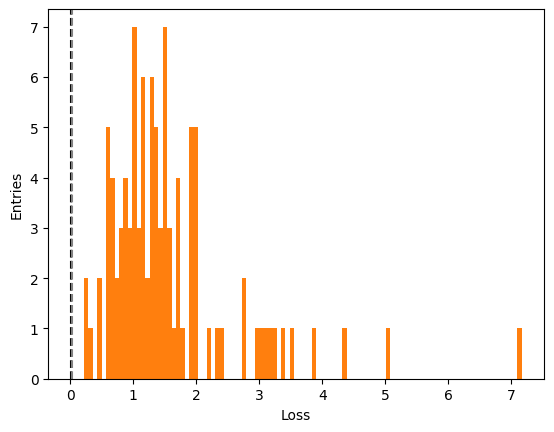

In [30]:
plt.hist(loss_evt.numpy(),100,color='C1')
plt.xlabel('Loss')
plt.ylabel('Entries')

ylim = plt.ylim()
plt.plot([.01]*2,ylim,'k--')
plt.plot([.03]*2,ylim,'grey',ls='--')
plt.ylim(ylim)

plt.show()

Nicole does some plotting now: to check/ have a look what scenarios the network is struggeling with/ solves easily. 

## Conclusion

In this notebook, we load a trained model, generate some data and evaluate it's performance. 

**Follow up**:
- How do we train a model? I should use a new loss? -> Yes yes loss, for the training, look at an other notebook (Invariant Slot Attention)
- What is the criteria we are looking at? How do we define if a network is good or bad? -> Separation of features. Group chat! Think of one!

**Questions to Nicole** 
- How to understand the networks architecture? -> Look at code!
- What is the aim? Seperating the rings as best as possible because we can derive all the desired information once the rings are seperated? - Yes
- How does the loss work?